In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('Agg')  # ใช้ backend แบบไม่ต้องโชว์ GUI
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # สลับ backend ให้แน่ใจว่าใช้ได้ในทุกระบบ

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix #ประเมินผลโมเดล
from sklearn.inspection import permutation_importance #การวัดความสำคัญของฟีเจอร์
from sklearn.preprocessing import LabelEncoder #การแปลงข้อมูลประเภทหมวดหมู่ให้เป็นตัวเลข


%matplotlib inline
# กำหนดค่าคงที่

sns.set(style="whitegrid") #ตั้งธีมของกราฟให้ดูเรียบง่าย สะอาด

# ตั้งค่าการแสดงผลให้มองเห็น DataFrame ชัดเจนขึ้น
pd.set_option("display.max_columns", None)   # แสดงทุกคอลัมน์
pd.set_option("display.max_rows", 100)       # แสดงได้มากสุด 100 แถว
pd.set_option("display.float_format", "{:.2f}".format)  # แสดงเลขทศนิยมแบบ 2 ตำแหน่ง


<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background:rgb(12, 83, 0); box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
    <div style="font-size:150%; color:rgb(144, 217, 234)"><b>วิเคราะห์พรีเมียร์ลีกและทำนายผลการแข่งขัน</b></div>
    <div>เป็นการนำมาศึกษาต่อจาก <a href="https://www.kaggle.com/code/devraai/premier-league-analysis-prediction" style="color:#6666FF">Brian Risk</a></div>
</div>

 
<div style = "text-align:center;">ในการวิเคราะห์นี้ จะเจาะลึกข้อมูลการแข่งขันพรีเมียร์ลีกตลอด 3 ฤดูกาลที่ผ่านมา  </div>


## Table of Contents

- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Prediction Model](#Prediction-Model)
- [Conclusion](#Conclusion)

In [7]:
# Load the data from the CSV file
data_path = 'data/PremierLeagueMatches.csv'
df = pd.read_csv(data_path)

print('Data loaded successfully. Shape:', df.shape)

Data loaded successfully. Shape: (1140, 14)


# Data Cleaning and Preprocessing

In [8]:
# แปลงคอลัมน์วันที่ให้เป็นชนิด datetime
try:
    df['Date'] = pd.to_datetime(df['Date'])
    print('Date conversion successful.')
except Exception as e:
    print('Error converting Date:', e)

# ตรวจสอบ Missing Values
print('Missing values per column:')
print(df.isnull().sum())

# ทำความสะอาดคอลัมน์ Attendance
if 'Attendance' in df.columns:
    df['Attendance'] = df['Attendance'].str.replace(',', '').astype('float', errors='ignore')

#ตรวจสอบประเภทของผลการแข่งขัน
print('Unique values in Result:')
print(df['Result'].unique())

df.head()

Date conversion successful.
Missing values per column:
Matchday              0
Date                  0
Time                  0
Home Team             0
homeScore            91
homeXG               91
awayScore            91
awayXG               91
Away Team             0
Attendance           95
Referee              91
Stadium               0
Result               91
*Additional Stats    91
dtype: int64
Unique values in Result:
['A' 'D' 'H' nan]


,Matchday,Date,Time,Home Team,homeScore,homeXG,awayScore,awayXG,Away Team,Attendance,Referee,Stadium,Result,*Additional Stats
0,1,2022-08-05,20:00,Crystal Palace,0.00,1.20,2.00,1.00,Arsenal,25286.00,Anthony Taylor,Selhurst Park,A,https://fbref.com//en/matches/e62f6e78/Crystal...
1,1,2022-08-06,12:30,Fulham,2.00,1.20,2.00,1.20,Liverpool,22207.00,Andy Madley,Craven Cottage,D,https://fbref.com//en/matches/6713c1dc/Fulham-...
2,1,2022-08-06,15:00,Tottenham,4.00,1.50,1.00,0.50,Southampton,61732.00,Andre Marriner,Tottenham Hotspur Stadium,H,https://fbref.com//en/matches/09d8a999/Tottenh...
3,1,2022-08-06,15:00,Newcastle Utd,2.00,1.70,0.00,0.30,Nott'ham Forest,52245.00,Simon Hooper,St James' Park,H,https://fbref.com//en/matches/1ac96eb4/Newcast...
4,1,2022-08-06,15:00,Leeds United,2.00,0.80,1.00,1.30,Wolves,36347.00,Robert Jones,Elland Road,H,https://fbref.com//en/matches/82702941/Leeds-U...


# Exploratory Data Analysis

       Matchday                           Date  homeScore  homeXG  awayScore  \
count   1140.00                           1140    1049.00 1049.00    1049.00   
mean      19.50  2024-01-07 15:04:25.263158016       1.66    1.63       1.38   
min        1.00            2022-08-05 00:00:00       0.00    0.00       0.00   
25%       10.00            2023-04-05 00:00:00       1.00    1.00       0.00   
50%       19.50            2023-12-30 00:00:00       1.00    1.50       1.00   
75%       29.00            2024-11-02 00:00:00       2.00    2.20       2.00   
max       38.00            2025-05-25 00:00:00       9.00    7.00       8.00   
std       10.97                            NaN       1.36    0.88       1.24   

       awayXG  Attendance  
count 1049.00     1045.00  
mean     1.32    39706.77  
min      0.00     9972.00  
25%      0.80    28978.00  
50%      1.20    38164.00  
75%      1.70    53316.00  
max      5.60    75546.00  
std      0.78    17068.16  


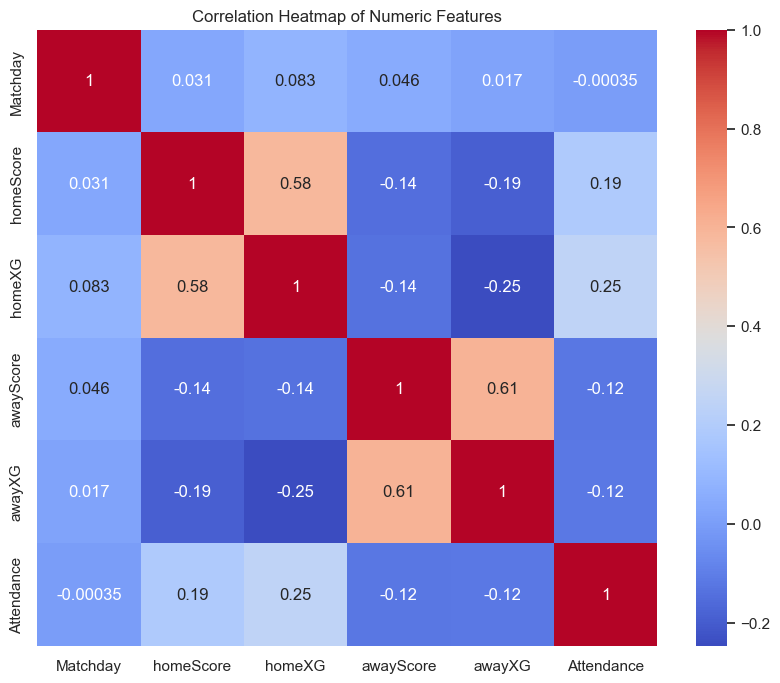

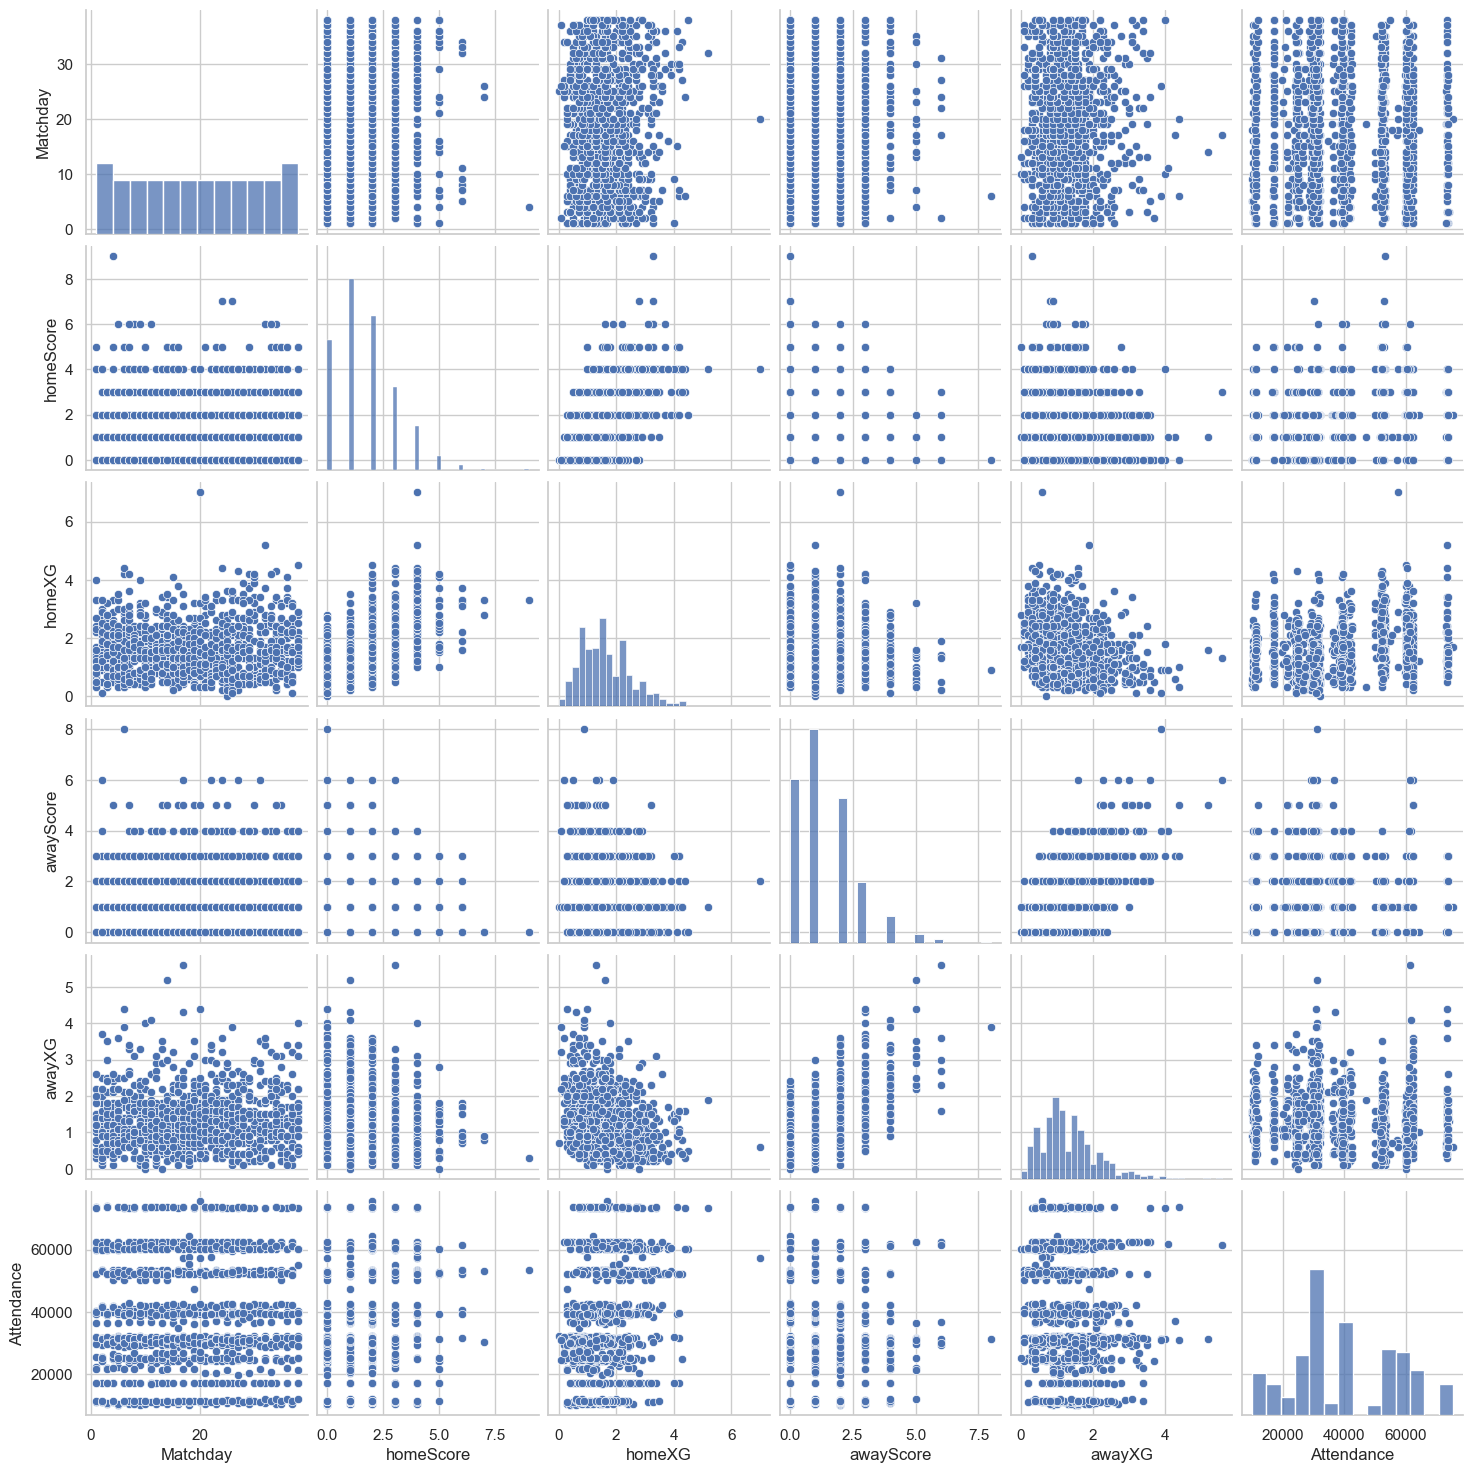

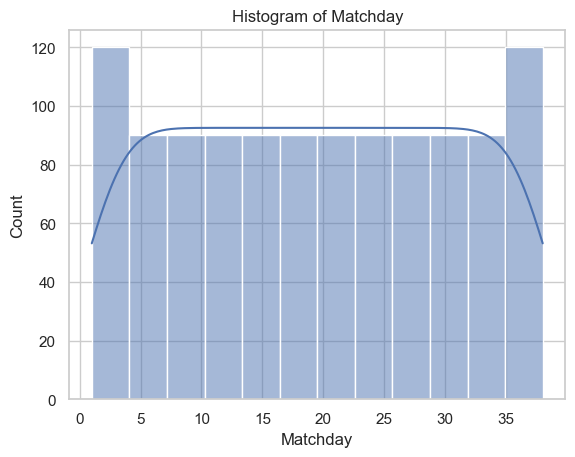

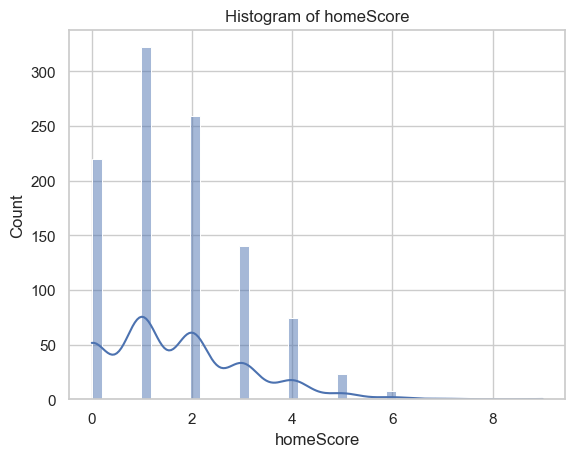

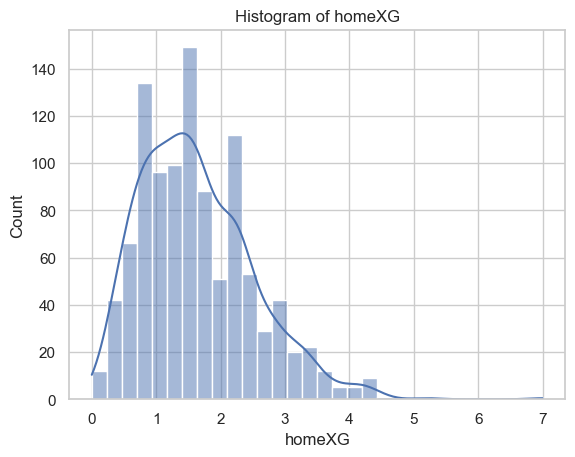

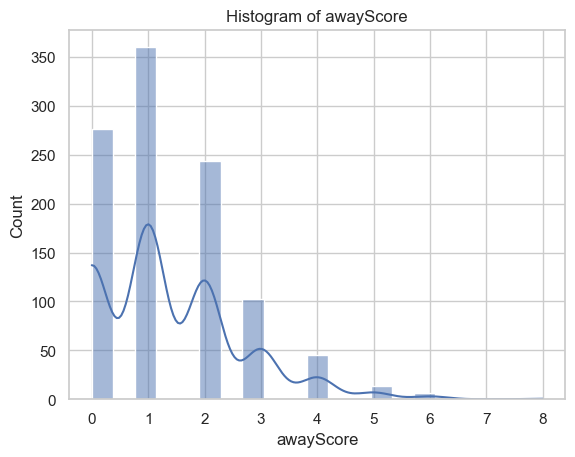

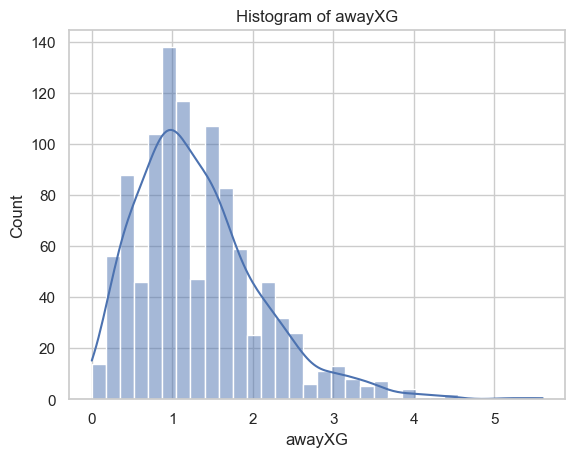

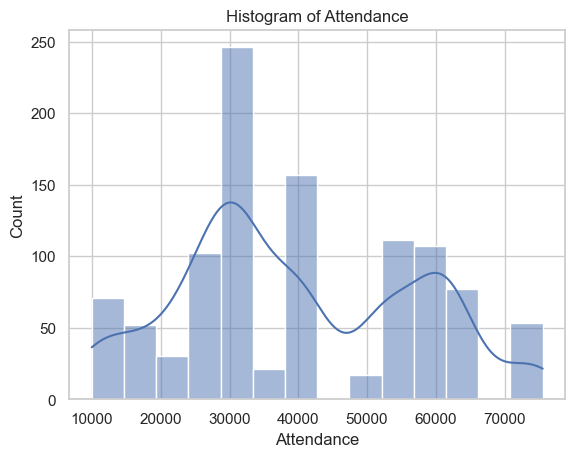

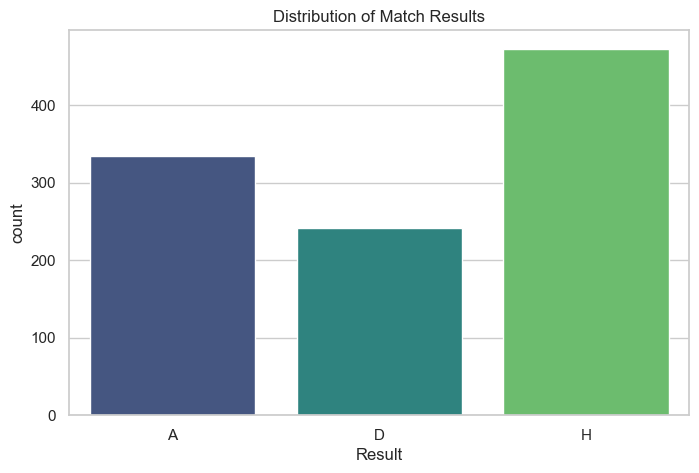

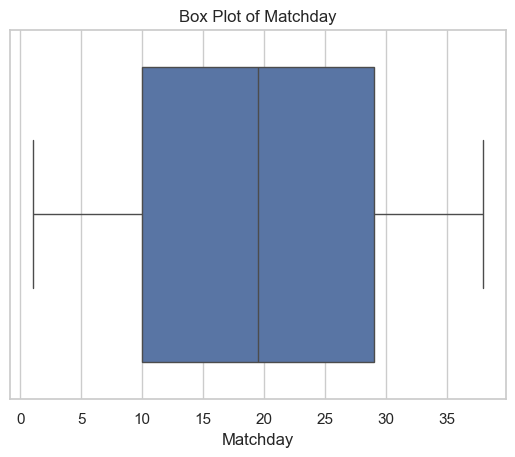

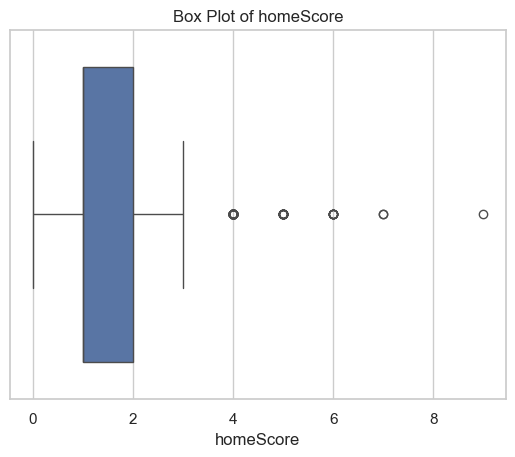

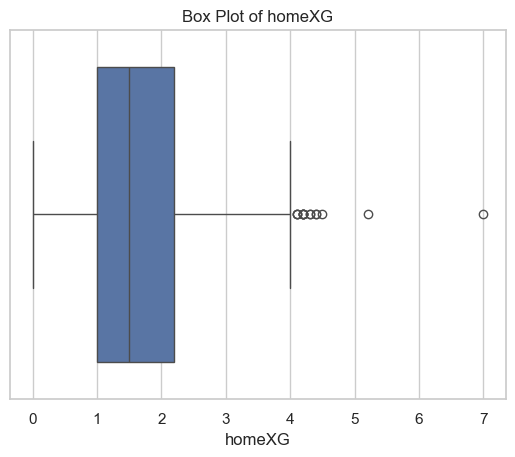

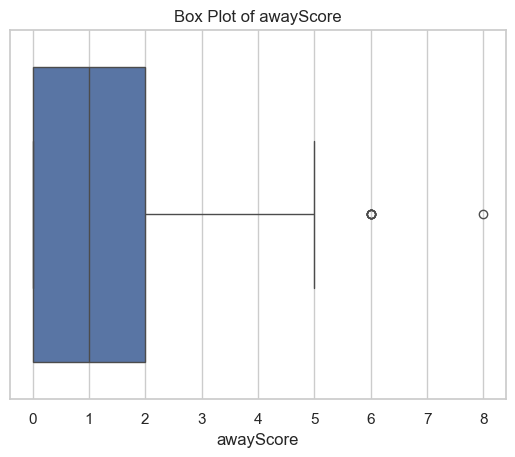

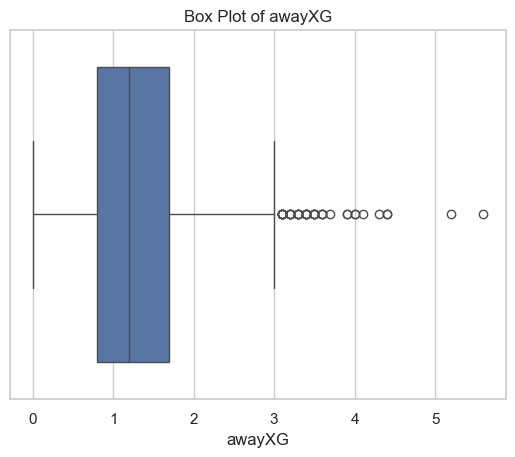

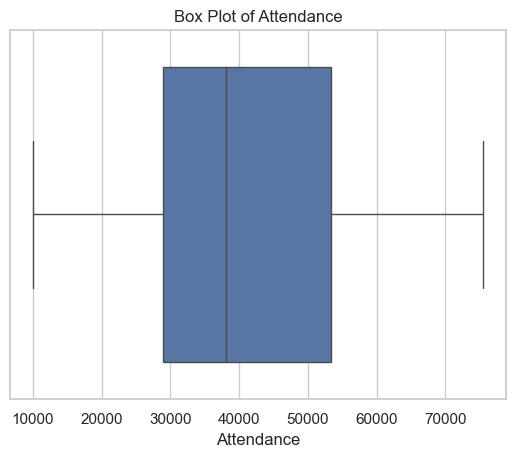

In [9]:
# สรุปสถิติเบื้องต้นของข้อมูลเชิงตัวเลข
print(df.describe())

#สร้าง Heatmap ความสัมพันธ์ระหว่างฟีเจอร์ตัวเลข
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

#Pair Plot – สำรวจความสัมพันธ์ระหว่างตัวเลขแบบ scatter
sns.pairplot(numeric_df)
plt.show()

#Histogram พร้อมเส้น KDE (การกระจายความน่าจะเป็น)
numeric_cols = numeric_df.columns
for col in numeric_cols:
    plt.figure()
    sns.histplot(numeric_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

#Count Plot สำหรับคอลัมน์ผลลัพธ์ Result
plt.figure(figsize=(8, 5))
sns.countplot(x='Result', data=df, palette='viridis')
plt.title('Distribution of Match Results')
plt.show()

#Box Plot – สำรวจ Outliers และการกระจาย
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=numeric_df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


# Prediction Model


In [24]:
import joblib
#เตรียมข้อมูลสำหรับเทรนโมเดล
features = ['Matchday', 'homeXG', 'awayXG']

#ตรวจสอบว่าคอลัมน์ครบและไม่มี missing
if not all(col in df.columns for col in features + ['Result']):
    raise ValueError('One or more required columns for prediction are missing.')

#ตัดแถวที่มีค่า Missing
predict_df = df[features + ['Result']].dropna()

#แยกฟีเจอร์ (X) กับผลลัพธ์ (y)
X = predict_df[features]
y = predict_df['Result']

#แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#สร้างและเทรนโมเดล Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#ทำนายและประเมินความแม่นยำ
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest model: {acc:.2f}')

#Confusion Matrix ดูว่าทำนายถูก/ผิดกี่ครั้งในแต่ละประเภทของ Result
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

#วิเคราะห์ความสำคัญของฟีเจอร์ (Permutation Importance)
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10)



joblib.dump(clf, 'xg_modeltest.pkl')
joblib.dump(le, 'label_encodertest.pkl')

print("✅ บันทึกโมเดลและ label encoder เรียบร้อยแล้ว!")

Accuracy of the Random Forest model: 0.50
✅ บันทึกโมเดลและ label encoder เรียบร้อยแล้ว!


# เพื่อเพิ่มประสิทธิภาพ

In [23]:
import joblib
# ฟีเจอร์ที่ปลอดภัย (ไม่รู้ผลลัพธ์จริง)
df['xG_diff'] = df['homeXG'] - df['awayXG']
features = ['homeXG', 'awayXG', 'xG_diff']

# Encode target
le = LabelEncoder()
df['Result_encoded'] = le.fit_transform(df['Result'])

# ลบ missing values
clean_df = df[features + ['Result_encoded']].dropna()

X = clean_df[features]
y = clean_df['Result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# สร้างและเทรนโมเดล
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=45)
clf.fit(X_train, y_train)

# ทำนายและวัดผล
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest model (no leakage): {acc:.2f}')


# บันทึกโมเดล และ LabelEncoder
joblib.dump(clf, 'xg_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("✅ บันทึกโมเดลและ label encoder เรียบร้อยแล้ว!")


Accuracy of the Random Forest model (no leakage): 0.51
✅ บันทึกโมเดลและ label encoder เรียบร้อยแล้ว!
